In [7]:
import os
import random
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
from tqdm import tqdm
import random
from skimage.draw import bezier_curve
from scipy.ndimage import gaussian_filter
import json

In [8]:
# Fix random seed for reproducibility
random.seed(42)
np.random.seed(42)
data_dir = './reduced_dset'

In [9]:
# === Paths ===
ann_file = os.path.join(data_dir, 'annotations', 'instances_train2014.json')
img_dir = os.path.join(data_dir, 'train2014')

# === Load COCO ===
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Segmentation: [174.22, 225.36, 190.8, 217.71, 225.25, 213.25, 254.58, 220.9, 271.8, 226.0, 276.27, 234.93, 271.8, 279.58, 239.91, 270.01, 232.26, 276.39, 266.06, 305.73, 234.17, 332.51, 240.55, 343.36, 286.47, 303.18, 287.75, 346.55, 277.54, 373.97, 268.62, 389.91, 239.28, 417.98, 206.11, 426.27, 193.36, 415.43, 186.98, 389.28, 191.44, 366.32, 193.99, 345.27, 190.8, 323.58, 186.98, 308.92, 181.24, 289.78, 178.69, 277.03, 153.18, 247.69, 153.18, 237.48, 172.31, 232.38]
Segmentation: [288.54, 342.47, 283.15, 291.24, 273.71, 268.31, 288.54, 235.96, 320.9, 222.47, 342.47, 214.38, 364.04, 225.17, 374.83, 256.18, 386.97, 300.67, 391.01, 330.34, 354.61, 355.96, 312.81, 355.96]
Segmentation: [464.79, 186.01, 465.18, 175.35, 467.95, 148.09, 475.45, 140.19, 480.99, 139.4, 488.49, 142.95, 493.63, 144.93, 489.68, 161.52, 488.89, 171.79, 486.91, 185.62, 492.05, 193.91, 499.95, 193.52, 494.02, 177.32, 494.81, 164.68, 498.76, 156.78, 501.13, 149.27, 507.45, 137.82, 512.98, 122.41, 511.8, 104.63, 506.

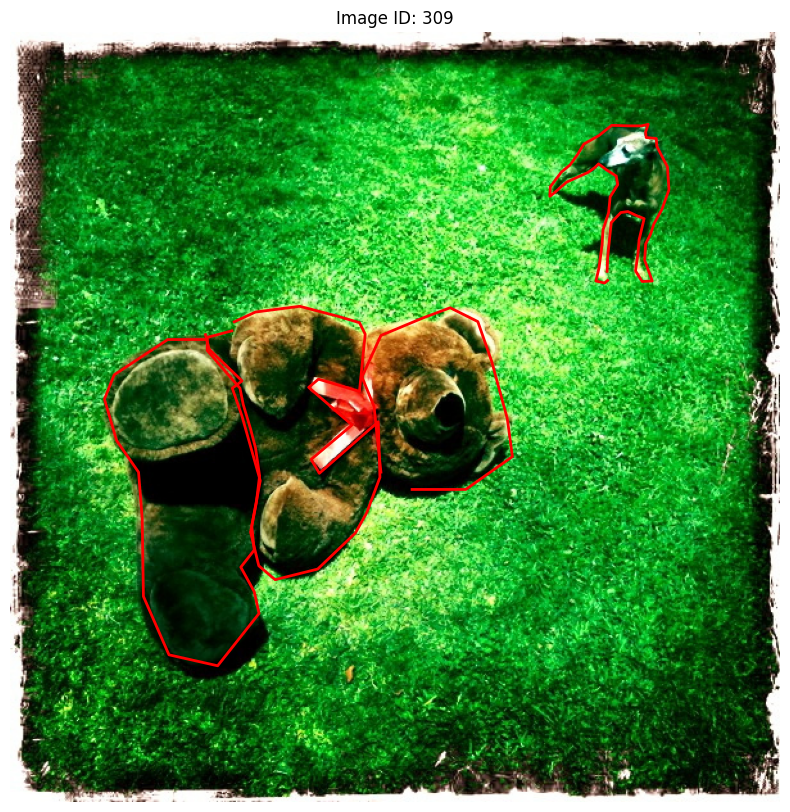

In [10]:
# === Select a random image ID ===
existing_ids = []
for img_id in coco.getImgIds():
    img_info = coco.loadImgs(img_id)[0]
    path = os.path.join(img_dir, img_info['file_name'])
    if os.path.exists(path):
        existing_ids.append(img_id)

# Ora scegli un'immagine valida
img_id = random.choice(existing_ids)
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(img_dir, img_info['file_name'])

# === Load image ===
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Get annotation ids and annotations for the image ===
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# === Plot image ===
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')

# === Overlay segmentations ===
for ann in anns:
    if 'segmentation' in ann:
        if type(ann['segmentation']) == list:
            for seg in ann['segmentation']:
                print(f"Segmentation: {seg}")
                poly = np.array(seg).reshape((int(len(seg)/2), 2))
                plt.plot(poly[:, 0], poly[:, 1], color='red', linewidth=2)

plt.title(f"Image ID: {img_id}")
plt.show()


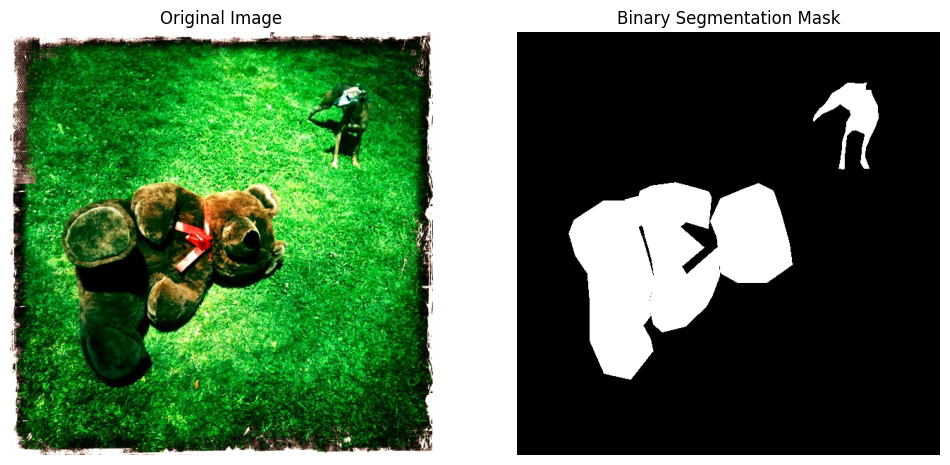

In [11]:
# === Load image ===
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width = image.shape[:2]

# === Load annotations ===
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# === Create binary mask ===
binary_mask = np.zeros((height, width), dtype=np.uint8)

for ann in anns:
    if 'segmentation' in ann:
        rle = coco.annToRLE(ann)
        mask = maskUtils.decode(rle)
        binary_mask = np.maximum(binary_mask, mask)  # union of all masks

# === Visualize ===
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Segmentation Mask')
plt.axis('off')

plt.show()


In [12]:
# === Paths ===
output_dir = os.path.join(data_dir, 'masks')

# Create output directory if not exists
os.makedirs(os.path.join(output_dir), exist_ok=True)

# === Load COCO ===
img_ids = existing_ids

print(f"Processing {len(img_ids)} images...")

for img_id in tqdm(img_ids):
    img_info = coco.loadImgs(img_id)[0]
    file_name = os.path.splitext(img_info['file_name'])[0]  # remove .jpg

    height, width = img_info['height'], img_info['width']
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    max_ann = len(anns)

    split_index = 0
    for ann in anns[:min(max_ann, 5)]: ## Limit to 5 annotations per image
        if 'segmentation' in ann and ann['iscrowd'] == 0:
            rle = coco.annToRLE(ann)
            mask = maskUtils.decode(rle)  # shape: (height, width), values: 0 or 1

            # Save mask
            output_name = f"{file_name}_splitmask{split_index}.npy"
            output_path = os.path.join(output_dir, output_name)
            np.save(output_path, mask.astype(np.uint8))
            split_index += 1


Processing 50 images...


100%|██████████| 50/50 [00:00<00:00, 88.16it/s]


In [13]:
print(f"Number of masks saved = {len([f for f in os.listdir(output_dir) if f.endswith('.npy')])}")

Number of masks saved = 198


In [14]:
input_dir = os.path.join(data_dir, 'masks')
output_dir = os.path.join(data_dir, 'coarse_masks')

os.makedirs(output_dir, exist_ok=True)

mask_files = [f for f in os.listdir(input_dir) if f.endswith('.npy')]

def random_coarse(mask):
    # Convert to uint8 and ensure contiguous
    mask = np.ascontiguousarray((mask * 255).astype(np.uint8))

    # Step 1: Generate a band around the edge
    contour_band = cv2.dilate(mask, np.ones((7, 7), np.uint8), iterations=1)
    contour_band = cv2.subtract(contour_band, mask)

    # Get coordinates where noise can be placed (in edge band)
    edge_coords = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, dtype=np.uint8)

    # Add random circles only around the contour area
    num_circles = random.randint(15, 40)
    for _ in range(num_circles):
        if len(edge_coords) == 0:
            break
        y, x = edge_coords[random.randint(0, len(edge_coords) - 1)]
        radius = random.randint(3, 10)
        cv2.circle(noise, (x, y), radius, 255, -1)

    # Combine noise with original mask
    mask = cv2.bitwise_or(mask, noise)

    # Step 2: Random dilation
    dilate_kernel_size = random.randint(7, 15)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_kernel_size, dilate_kernel_size))
    mask = cv2.dilate(mask, kernel_dilate, iterations=random.randint(1, 2))

    # Step 3: Random erosion
    erode_kernel_size = random.randint(5, dilate_kernel_size - 1)
    kernel_erode = cv2.getStructuringElement(random.choice([
        cv2.MORPH_ELLIPSE, cv2.MORPH_RECT, cv2.MORPH_CROSS
    ]), (erode_kernel_size, erode_kernel_size))
    mask = cv2.erode(mask, kernel_erode, iterations=1)

    # Step 4: Gaussian blur + threshold for soft borders
    blur = cv2.GaussianBlur(mask, (5, 5), sigmaX=random.uniform(2.0, 4.5))
    _, coarse_mask = cv2.threshold(blur, random.randint(60, 120), 1, cv2.THRESH_BINARY)

    return coarse_mask.astype(np.uint8)


def random_coarse_v2(mask):
    mask = np.ascontiguousarray((mask > 0).astype(np.uint8) * 255)

    band_width   = random.randint(15, 40)                      
    contour_band = cv2.dilate(mask,
                              cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                                        (band_width, band_width)),
                              iterations=1)
    contour_band = cv2.subtract(contour_band, mask)
    edge_coords  = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, np.uint8)
    num_circles = random.randint(8, 18)                        
    for _ in range(num_circles):
        y, x = edge_coords[random.randrange(len(edge_coords))]
        radius = random.randint(band_width//2, band_width)     
        cv2.circle(noise, (x, y), radius, 255, -1)

    mask = cv2.bitwise_or(mask, noise)

    close_size = random.randint(band_width//2, band_width)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (close_size, close_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

    blur = cv2.GaussianBlur(mask, (0, 0), sigmaX=random.uniform(6.0, 12.0)) 
    _, coarse = cv2.threshold(blur, 127, 1, cv2.THRESH_BINARY)

    return coarse.astype(np.uint8)


def random_coarse_distanza(mask, sigma_noise=12, blur_sigma=6.0, bias=12):

    mask = (mask > 0).astype(np.uint8)

    d_in  = cv2.distanceTransform(mask,  cv2.DIST_L2, 3)
    d_out = cv2.distanceTransform(1-mask, cv2.DIST_L2, 3)
    signed = d_in - d_out                 

    noise = np.random.randn(*mask.shape).astype(np.float32)
    noise = cv2.GaussianBlur(noise, (0,0), blur_sigma)

    d_hat = signed + sigma_noise * noise - bias
    coarse = (d_hat > 0).astype(np.uint8)

    return coarse



print(f"Generating coarse masks for {len(mask_files)} masks...")

for fname in tqdm(mask_files):
    mask_path = os.path.join(input_dir, fname)
    mask = np.load(mask_path)  # shape: (H, W)

    coarse_mask = random_coarse_v2(mask)
    
    # Save new mask
    coarse_name = fname.replace('splitmask', 'coarsemask')
    output_path = os.path.join(output_dir, coarse_name)
    np.save(output_path, coarse_mask)

Generating coarse masks for 198 masks...


100%|██████████| 198/198 [00:11<00:00, 16.83it/s]


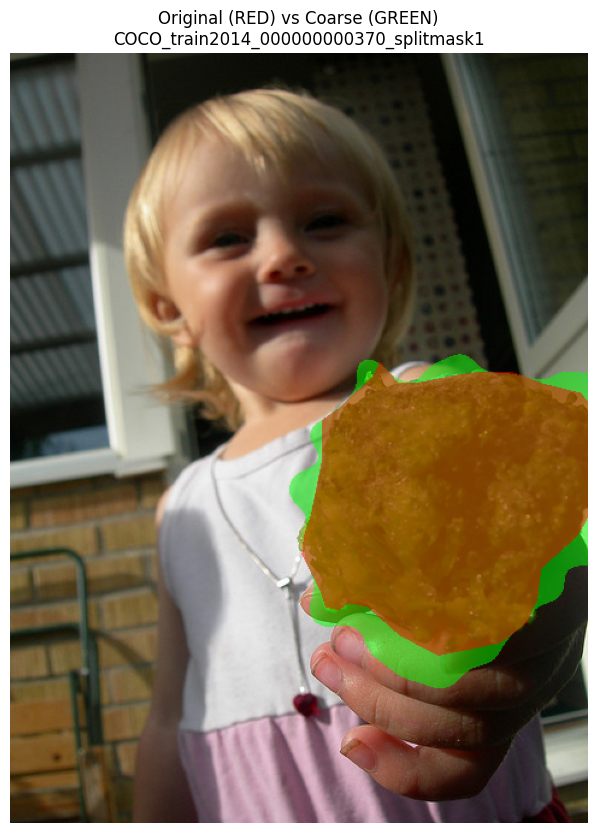

In [41]:
# === Paths ===
masks_dir = os.path.join(data_dir, 'masks')
coarse_dir = os.path.join(data_dir, 'coarse_masks')

# === Pick a random mask ===
mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.npy')]
random_mask_file = random.choice(mask_files)

# === Parse image info ===
# mask filename format: {img_id}_splitmask{i}.npy
img_id, split_info = random_mask_file.replace('.npy', '').split('_splitmask')
split_i = int(split_info)

# === Construct paths ===
img_path = os.path.join(img_dir, f'{img_id}.jpg')
orig_mask_path = os.path.join(masks_dir, random_mask_file)
coarse_mask_path = os.path.join(coarse_dir, random_mask_file.replace('splitmask', 'coarsemask'))

# === Load image and masks ===
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

orig_mask = np.load(orig_mask_path)
coarse_mask = np.load(coarse_mask_path)

# === Overlay the masks ===
overlay = img.copy().astype(np.float32) / 255.0

# Green for coarse
overlay[coarse_mask == 1] = overlay[coarse_mask == 1] * 0.5 + np.array([0, 1, 0]) * 0.5

# Red for original
overlay[orig_mask == 1] = overlay[orig_mask == 1] * 0.5 + np.array([1, 0, 0]) * 0.5

# === Show it ===
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.title(f"Original (RED) vs Coarse (GREEN)\n{img_id}_splitmask{split_i}")
plt.axis('off')
plt.show()
